In [1]:
import sys

sys.path.append('../src/')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mrpython_pcl.LidarPipeline.ConeClassifier import ConeClassifier

import utils

## Lidar Settings

In [2]:
import yaml

with open('lidar_datasheet.yml', 'r') as f:
    data = yaml.safe_load(f)
    
LIDAR_VERTICAL_INCLINATION = -1.5 # DEGREES
LIDAR_ORIGIN = (0,0,0.4) # METERS
LIDAR_VERTICAL_ANGLES = (np.array(data['LIDAR_VERTICAL_ANGLES'] ) + LIDAR_VERTICAL_INCLINATION).tolist()
LIDAR_POSITION_ACCURACY = data['LIDAR_POSITION_ACCURACY']
LIDAR_HORIZONTAL_FOV = data['LIDAR_HORIZONTAL_FOV']
LIDAR_RATE = data['LIDAR_RATE']
LIDAR_RATE_ACCURACY = data['LIDAR_RATE_ACCURACY']
# Calculate horizontal angle offset according to RPM
calculateHorizontalAzmuth = lambda rpm: rpm/60 * 360 * 55.269e-6 # degrees

## Cone Settings

In [3]:
N_SAMPLES = 100 # number of cone samples per distance to generate

# CONE CONSTANTS
CONE_HEIGHT = 0.33 # METERS
CONE_RADIUS = 0.1 # METERS

## Simulate LiDAR Intersections

In [10]:
def simulateLidar(d):
    # sample N_SAMPLES cones
    classifier = ConeClassifier(CONE_RADIUS, CONE_HEIGHT, 1,1,1)
    
    costTracker = {'linLoss':[], 'l2Loss':[], 'num_points':[]}
    
    for i in range(N_SAMPLES):
        cones = []
        angle = np.random.uniform(low=0, high=LIDAR_HORIZONTAL_FOV)
        cone = utils.getConeEquation(angle, d, CONE_HEIGHT, CONE_RADIUS)
        cones.append(cone)
        
        # scan using the lidar
        rotationAngle = np.rad2deg(np.arctan(CONE_RADIUS/d))
        intersections = []
        alpha = angle-rotationAngle
        
        for alpha in LIDAR_VERTICAL_ANGLES: # vertical angle
            theta = angle-rotationAngle
            while theta < angle+rotationAngle: # horizontal angle
                # get lidar ray
                ray = utils.getLineEquation(LIDAR_ORIGIN, alpha, theta)
                # get intersection point
                intersection = utils.computeIntersection(cone, ray)
                
                if intersection is not None:
                    if intersection[2]>=0 and intersection[2]<=CONE_HEIGHT:
                        #utils.visualizeLineAndCone(ray[:2],ray[3:5],cone[:2],CONE_RADIUS)
                        #print(intersection)
                        intersection = [np.random.normal(intersection[0], LIDAR_POSITION_ACCURACY), np.random.normal(intersection[1], LIDAR_POSITION_ACCURACY), intersection[2]]
                        intersections.append(intersection)

                rpm=np.random.uniform(low=LIDAR_RATE-LIDAR_RATE_ACCURACY, high=LIDAR_RATE+LIDAR_RATE_ACCURACY)
                theta+=calculateHorizontalAzmuth(rpm)
                
        # use the points to fit the X_c and y_c
        intersections = np.array(intersections)
        try:
            (_, linLoss, l2Loss), _ = classifier.isCone(intersections, returnLosses=True)
            costTracker['linLoss'].append(linLoss)
            
            # compute the sum of cost2
            costTracker['l2Loss'].append(l2Loss)
            
            # append number of points
            costTracker['num_points'].append(len(intersections))
        except:
            pass
        finally:
            costTracker['num_points'].append(len(intersections))
        
                    
    # compute the mean and std of sigma_cost1 and sigma_cost2
    thres1_mean = np.mean(costTracker['linLoss'])
    thres1_std = np.std(costTracker['linLoss'])
    thres2_mean = np.mean(costTracker['l2Loss'])
    thres2_std = np.std(costTracker['l2Loss'])
    mean_num_intersections = np.mean(costTracker['num_points'])
    
    return thres1_mean, thres1_std, thres2_mean, thres2_std, mean_num_intersections, costTracker

In [11]:
thres1_mean, thres1_std, thres2_mean, thres2_std, avg_num_points,_ = simulateLidar(1)
thres1_mean, thres1_std, thres2_mean, thres2_std,avg_num_points

(4.267441456486862e-06,
 1.2231612704400786e-06,
 0.017453271995489076,
 0.005047242423920317,
 97.33)

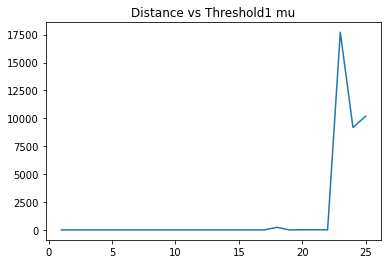

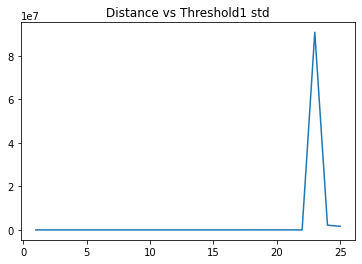

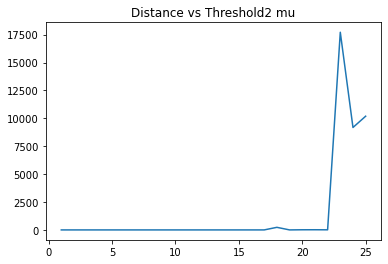

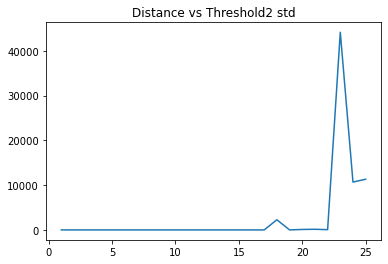

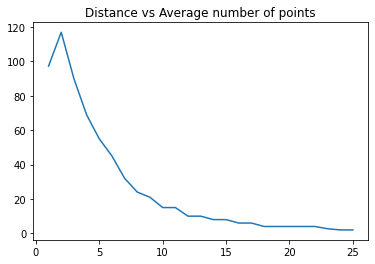

In [12]:
# simulate on many distances
t1MUList = []
t1STDList = []
t2MUList = []
t2STDList = []
avgNumPointsList = []

for i in range(1,25+1):
    t1MU, t1STD, t1MU, t2STD, avgNumPoints, _ = simulateLidar(i)
    t1MUList.append(t1MU)
    t1STDList.append(t1STD)
    t2MUList.append(t1MU)
    t2STDList.append(t2STD)
    avgNumPointsList.append(avgNumPoints)

distance_list = np.arange(1,25+1)
plt.plot(distance_list, t1MUList)
plt.title('Distance vs Threshold1 mu')
plt.show()
plt.plot(distance_list, t1STDList)
plt.title('Distance vs Threshold1 std')
plt.show()
plt.plot(distance_list, t2MUList)
plt.title('Distance vs Threshold2 mu')
plt.show()
plt.plot(distance_list, t2STDList)
plt.title('Distance vs Threshold2 std')
plt.show()
plt.plot(distance_list, avgNumPointsList)
plt.title('Distance vs Average number of points')
plt.show()

In [9]:
# determine the inclintation with the max total points
minInclintation = -10
maxInclintation = 0
inclintationWithMaxPoints = minInclintation
previousTotalPoints = 0
totalPointsList = []
for j in range(minInclintation,maxInclintation+1,1):
    LIDAR_VERTICAL_INCLINATION = j
    LIDAR_VERTICAL_ANGLES = (np.array(data['LIDAR_VERTICAL_ANGLES'] ) + LIDAR_VERTICAL_INCLINATION).tolist()

    totalPoints = 0
    for i in range(1,25+1):
        *_, avgNumPoints, _ = simulateLidar(i)
        totalPoints+=avgNumPoints
    totalPointsList.append(totalPoints)
    if totalPoints>previousTotalPoints:
        previousTotalPoints = totalPoints
        inclintationWithMaxPoints = j
    
print('inclintationWithMaxPoints', inclintationWithMaxPoints, 'degrees')

d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


inclintationWithMaxPoints -8 degrees


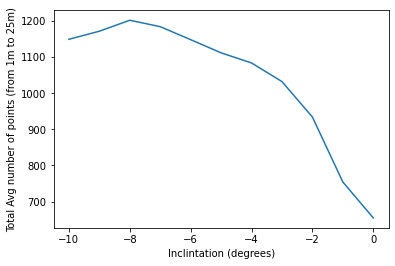

In [10]:
b

In [11]:
minFocusAngle = -9
maxFocusAngle = -7
inclintationWithMaxPoints = minFocusAngle
previousTotalPoints = 0
totalPointsList = []
j = minFocusAngle

while j<=maxFocusAngle:
    LIDAR_VERTICAL_INCLINATION = j
    LIDAR_VERTICAL_ANGLES = (np.array(data['LIDAR_VERTICAL_ANGLES'] ) + LIDAR_VERTICAL_INCLINATION).tolist()

    totalPoints = 0
    for i in range(1,25+1):
        *_, avgNumPoints, _ = simulateLidar(i)
        totalPoints+=avgNumPoints
    totalPointsList.append(totalPoints)
    if totalPoints>previousTotalPoints:
        previousTotalPoints = totalPoints
        inclintationWithMaxPoints = j
    j+=0.1
    
print('inclintationWithMaxPoints', inclintationWithMaxPoints, 'degrees')

d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\Apps\Anaconda\Anaconda\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


inclintationWithMaxPoints -7.800000000000004 degrees


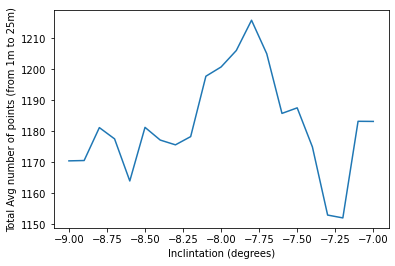

In [18]:
plt.plot(np.arange(-9,-6.9,0.1), totalPointsList)
plt.xlabel('Inclintation (degrees)')
plt.ylabel('Total Avg number of points (from 1m to 25m)')
plt.show()